In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
from vmdpy import VMD  
import akshare as ak #大豆数据集
from scipy.fftpack import fft ##傅里叶级数
import pkuseg   #分词包
import re

#下载数据
Data=pd.read_csv("/Volumes/本机/paper/futures voality forcaseting/VMD_BiLSTM_A0/Data/data.csv")
Data.head()

,Unnamed: 0,date,open,high,low,close,volume,hold,settle
0,1,2010/1/4,4080,4090,4049,4057,321838,284296,0
1,2,2010/1/5,4067,4082,4060,4066,253640,283384,0
2,3,2010/1/6,4066,4194,4057,4154,860812,352830,0
3,4,2010/1/7,4165,4188,3975,4044,705704,297236,0
4,5,2010/1/8,4040,4050,3947,3981,526594,270074,0


In [2]:
#数据处理
pd.to_datetime(Data.date)

0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
2422   2019-12-25
2423   2019-12-26
2424   2019-12-27
2425   2019-12-30
2426   2019-12-31
Name: date, Length: 2427, dtype: datetime64[ns]

Text(0.5, 1.0, 'Decomposed modes')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


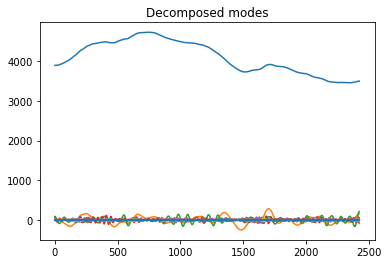

In [3]:
#Vmd分解

#1.导入文件，可以指定列也可以，就是usercol
filename= '/Volumes/本机/paper/futures voality forcaseting/VMD_BiLSTM_A0/Data/data.csv'
f = pd.read_csv(filename,usecols=[5])

#vmd包参数设置并执行VMD
alpha = 5000       #宽带限制，一般为数据点的1.5-2倍  
tau = 0.           # 噪声限制 (no strict fidelity enforcement)  
K = 11             # 分解模态个数  
DC = 0             # 合成信号若无常量则为0；若含常量，则其取值为 1；  
init = 1           # 初始化ω值,当初始化为1时,均匀分布产生的随机数； 
tol = 1e-7         # 控制误差大小常量，决定精度与迭代次数

u, u_hat, omega = VMD(f.close, alpha, tau, K, DC, init, tol)  

#绘制分解模态图
plt.figure()
plt.plot(u.T)
plt.title('Decomposed modes')

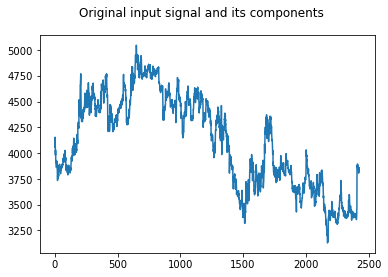

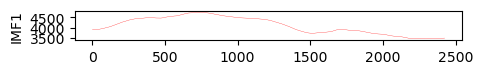

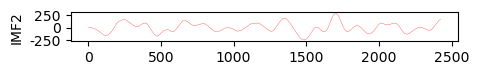

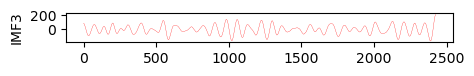

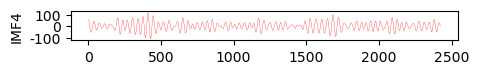

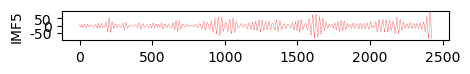

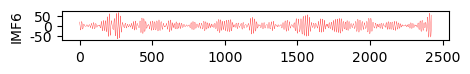

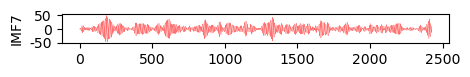

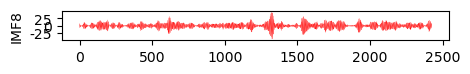

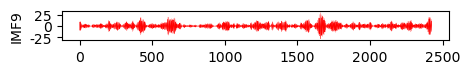

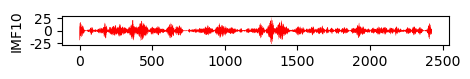

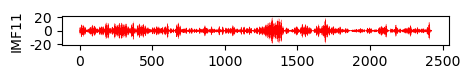

In [4]:
#未分解前的图
fig1 = plt.figure()
plt.plot(f.close)
fig1.suptitle('Original input signal and its components')

#循环每个分解模态的
for i in range(K):
    plt.figure(figsize=(5,5), dpi=100)
    plt.subplot(K,1,i+1)
    plt.plot(u[i,:], linewidth=0.2, c='r')
    plt.ylabel('IMF{}'.format(i+1))

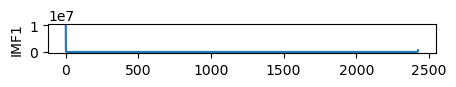

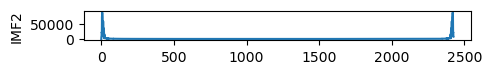

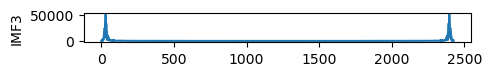

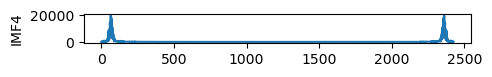

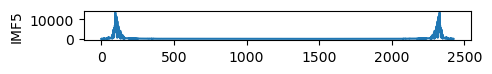

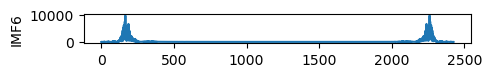

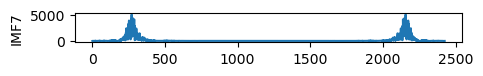

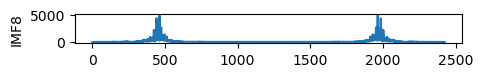

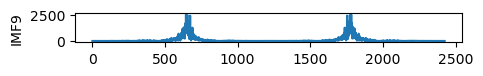

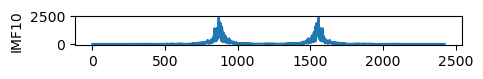

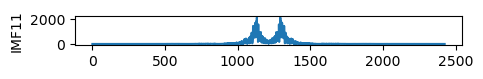

In [5]:
#每个模态的中心频率
for i in range(K):
    plt.figure(figsize=(5,5), dpi=100)
    plt.subplot(K,1,i+1)
    plt.plot(abs(fft(u[i,:])))
    plt.ylabel('IMF{}'.format(i+1))


In [6]:
filepath1='/Volumes/本机/paper/futures voality forcaseting/VMD_BiLSTM_A0/Data/text.csv'
text=pd.read_csv(filepath1)
pd.to_datetime(text.date)

0      2019-07-01
1      2019-06-06
2      2019-05-13
3      2019-04-25
4      2019-04-08
          ...    
3286   2010-01-06
3287   2010-01-05
3288   2010-01-05
3289   2010-01-04
3290   2010-01-04
Name: date, Length: 3291, dtype: datetime64[ns]

In [17]:
titles=text.title
print(titles)
#遍历series
import pkuseg

AttributeError: 'list' object has no attribute 'title'

In [15]:
text_pro=titles.spilt()

AttributeError: 'Series' object has no attribute 'spilt'

In [16]:
import pkuseg

seg = pkuseg.pkuseg()           # 以默认配置加载模型
text = seg.cut('我爱北京天安门')  # 进行分词
print(text)

['我', '爱', '北京', '天安门']
